In [35]:
# our basic libraries
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size=20

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN
data_transform = transforms.ToTensor()

# Download and load the training data
trainset = FashionMNIST('F_MNIST_data/', download=True, train=True, transform=data_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = FashionMNIST('F_MNIST_data/', download=True, train=False, transform=data_transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [3]:
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

Train data, number of images:  60000
Test data, number of images:  10000


In [4]:
images, labels = next(iter(trainloader))
images.size()

torch.Size([20, 1, 28, 28])

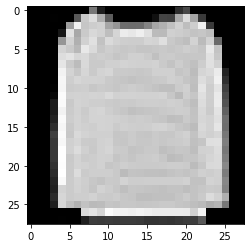

In [18]:
plt.imshow(images[1].numpy().squeeze(), cmap='gray')

In [4]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        # from (1, 28, 28) to (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        ## TODO: Define the rest of the layers:
        # include another conv layer, maxpooling layers, and linear layers
        # also consider adding a dropout layer to avoid overfitting
        # from (10, 26, 26) to (10, 13, 13)
        # from (20, 11, 11) to (20, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        # from (10, 13, 13) to (20, 11, 11)
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # from (20, 5, 5) to (50)
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # from (50) to (10)
        self.fc2 = nn.Linear(50, 10)
        

    ## TODO: define the feedforward behavior
    def forward(self, x):
        # one activated conv layer
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # two linear layers 
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        
        # final output
        return x


# instantiate and print your Net
model = Model()
print(model)

Model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [5]:
# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.NLLLoss()

# stochastic gradient descent with a small learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [6]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070 with Max-Q Design'

In [18]:
def train(n_epochs):
    
    # to track training loss over time
    loss_over_time = []
    
    # move model to GPU
    model.to("cuda")

    for epoch in range(n_epochs):
        
        running_loss = 0.0
        
        for batch_i, (images, labels) in enumerate(trainloader):
            
            # move images and label tensors to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            
            #zero the weight gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            outputs = model(images)
            
            # calculate the loss
            loss = criterion(outputs, labels)
            
            # backward pass to calculate the parameter gradients
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            # print every 1000 batches
            if batch_i%1000 == 999:
                
                # Make sure model is in eval mode for inference
                model.eval()
                
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                training_loss = running_loss/1000
                
                print('Epoch: {}/{}.. '.format(epoch+1, n_epochs),
                      'Batch: {}.. '.format(batch_i+1),
                      'Training Loss: {:.3f}.. '.format(training_loss),
                      'Test Loss: {:.3f}.. '.format(test_loss/len(testloader)),
                      'Test Accuracy: {:.3f}.. '.format(accuracy/len(testloader)))
                      
                running_loss = 0.0
                
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(training_loss)
                      
                    
                # Make sure model is back in train mode
                model.train()
                
    print("Finished training")
    return loss_over_time

In [19]:
n_epochs = 5

training_loss = train(n_epochs)

Epoch: 1/5..  Batch: 1000..  Training Loss: 0.705..  Test Loss: 0.633..  Test Accuracy: 0.762.. 
Epoch: 1/5..  Batch: 2000..  Training Loss: 0.697..  Test Loss: 0.627..  Test Accuracy: 0.766.. 
Epoch: 1/5..  Batch: 3000..  Training Loss: 0.698..  Test Loss: 0.625..  Test Accuracy: 0.766.. 
Epoch: 2/5..  Batch: 1000..  Training Loss: 0.682..  Test Loss: 0.618..  Test Accuracy: 0.765.. 
Epoch: 2/5..  Batch: 2000..  Training Loss: 0.687..  Test Loss: 0.617..  Test Accuracy: 0.767.. 
Epoch: 2/5..  Batch: 3000..  Training Loss: 0.692..  Test Loss: 0.616..  Test Accuracy: 0.767.. 
Epoch: 3/5..  Batch: 1000..  Training Loss: 0.670..  Test Loss: 0.615..  Test Accuracy: 0.761.. 
Epoch: 3/5..  Batch: 2000..  Training Loss: 0.672..  Test Loss: 0.607..  Test Accuracy: 0.762.. 
Epoch: 3/5..  Batch: 3000..  Training Loss: 0.663..  Test Loss: 0.598..  Test Accuracy: 0.776.. 
Epoch: 4/5..  Batch: 1000..  Training Loss: 0.655..  Test Loss: 0.603..  Test Accuracy: 0.771.. 
Epoch: 4/5..  Batch: 2000..  T

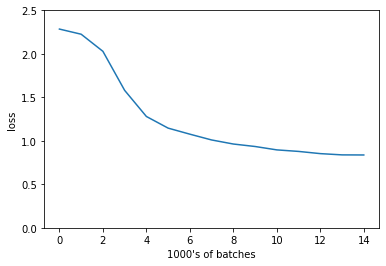

In [9]:
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

In [17]:
def validation(model, testloader, criterion):
    # set model to eval mode to avoid applying dropout
    model.eval()

    # move model to GPU
    model.to("cuda")

    test_loss = 0
    accuracy = 0

    for batch_i, (images, labels) in enumerate(testloader):

        # move images and label tensors to GPU
        images = images.to("cuda")
        labels = labels.to("cuda")

        outputs = model(images)

        loss = criterion(outputs, labels)

        test_loss += loss.item()

        # because output is log(softmax), so taking exp returns softmax
        # ps shape is torch.Size([batch_size, no_of_classes]) or (20,10)
        ps = torch.exp(outputs)

        # dim=1 is across the 10, while dim=0 is across the 20
        # ps.max(dim=1) returns two tensors, [0] with highest probabilities
        # [1] with the labels of the highest probabilities
        # equality returns a tensor of 0 and 1s, where 1 are correct preds
        equality = (labels == ps.max(dim=1)[1])

        # change from torch.ByteTensor to torch.FloatTensor for mean() to work
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy


## Feature Visualization

In [30]:
# Move from GPU to CPU so that we can use numpy
model.to("cpu")
images = images.to("cpu")

First convolutional layer


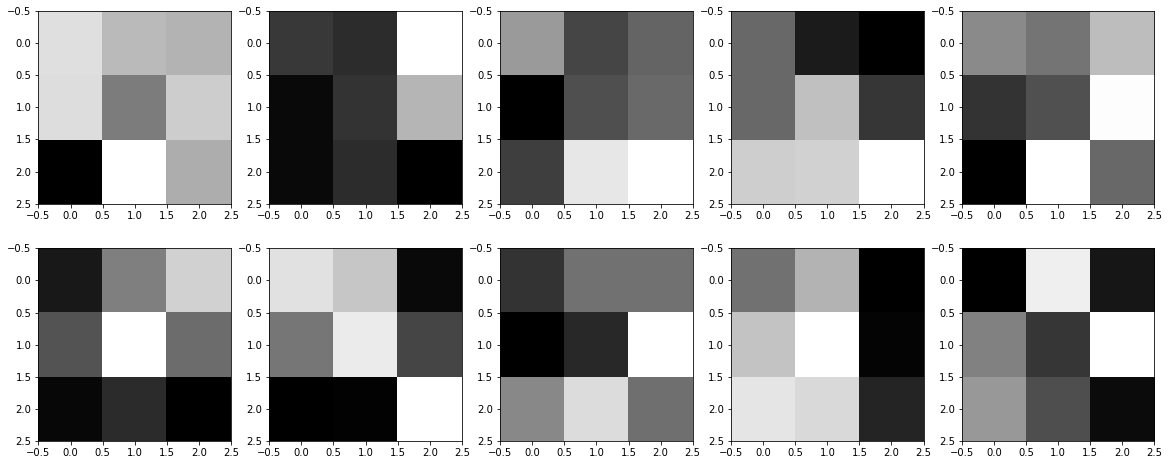

In [31]:
# Get the weights in the first conv layer
weights = model.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

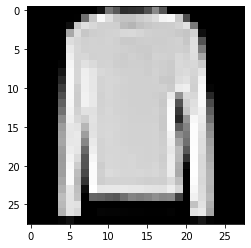

In [33]:
img = images[1].numpy().squeeze()
plt.imshow(img, cmap='gray')

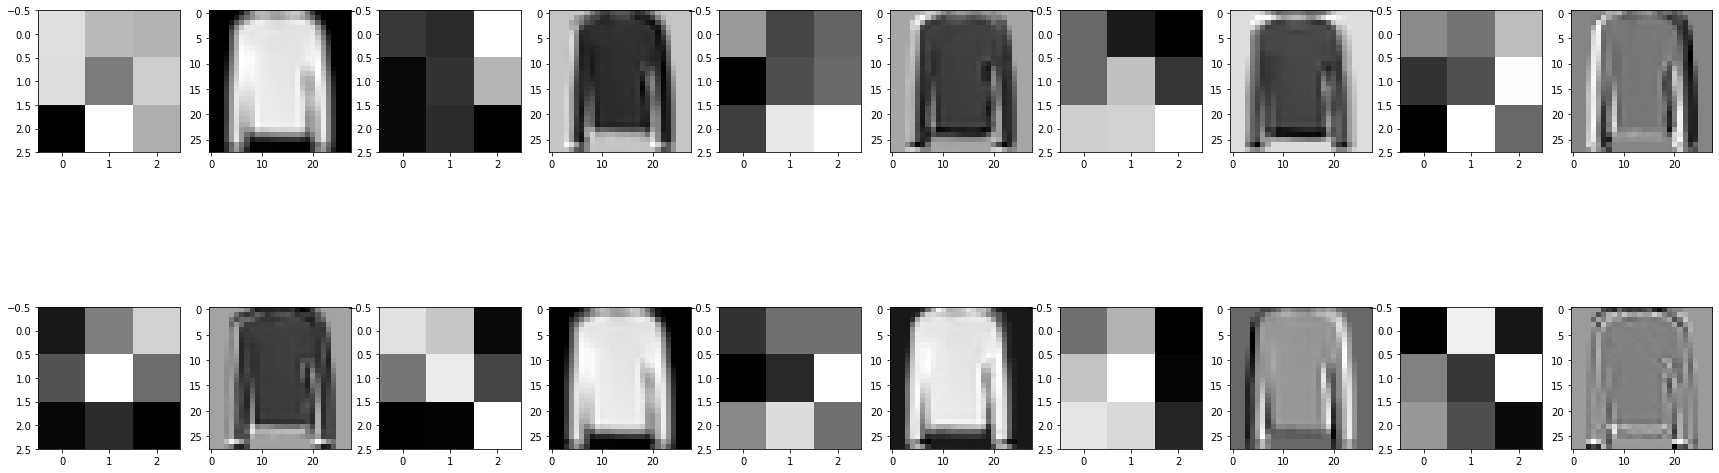

In [36]:
# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

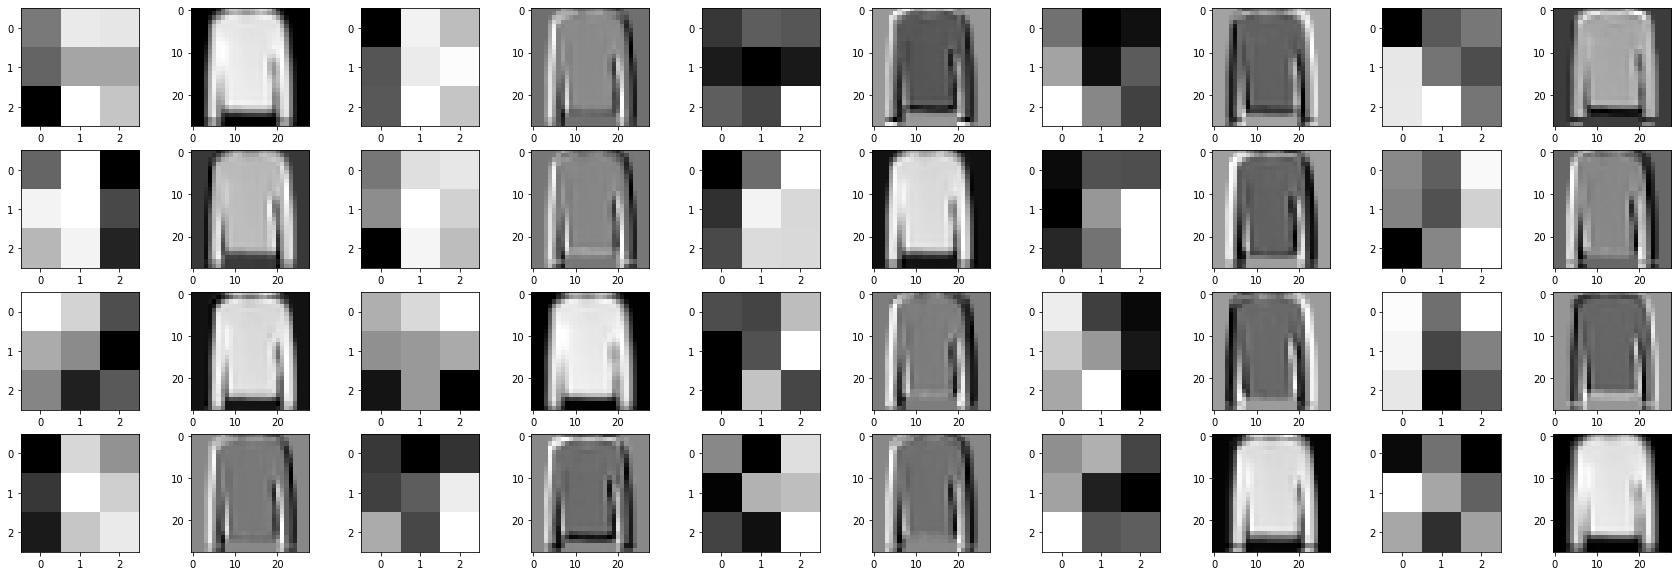

In [38]:
# second conv layer, conv2
weights = model.conv2.weight.data
w = weights.numpy()

# 2. second conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

For conv1, row 2 col 4 image appears to detect vertical edges.
For conv2, row 1 col 1 image seems to be detecting the pullover as it is the brightest colour in the filtered image.

## Saving and Loading the Model

In [ ]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'fashion_net_simple.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(model.state_dict(), model_dir+model_name)

In [ ]:
# instantiate your Net
model = Model()

# load the net parameters by name
model.load_state_dict(torch.load('saved_models/fashion_net_ex.pt'))

print(model)